# Calculating portfolio returns 
* This is the same exact file as portfolio investing but instead of using BTC, we have actual stock data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
achc = pd.read_csv('ACHC.csv', parse_dates=['Date'])
achc = achc.sort_values(by='Date')
achc.set_index('Date', inplace=True)

In [3]:
# calculate daily returns
achc['Returns'] = achc['Adj Close'].pct_change()
achc['Returns'].head()

Date
2016-12-12         NaN
2016-12-13   -0.035675
2016-12-14   -0.037283
2016-12-15    0.035725
2016-12-16    0.019130
Name: Returns, dtype: float64

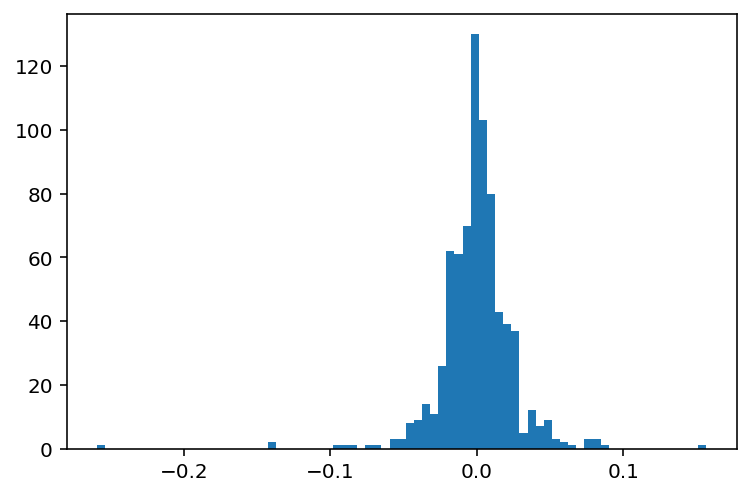

In [4]:
# visualize returns
plt.hist(achc['Returns'].dropna(), bins=75, density=False)
plt.show();

In order to build a backtest portfolio we need to have the returns of multiple assets in a single object

Our model portfolio consists of the following companies and the weight in our portfolio represented by percentages:
* Apple 12%
* Microsoft 15%
* Exxon Mobil 8%
* JP Morgan 9%
* Amazon 10%
* Facebook 5%
* AT&T 16%
* Tesla 15%
* Gold 10%

In [5]:
# calculate mean returns
mean_return_daily = np.mean(achc['Returns'])
print(mean_return_daily)

0.0001509405969682483


In [6]:
# calculate implied annualized average return assuming 252 trading days in a year
mean_return_annualized = ((1 + np.mean(achc['Returns'])) ** 252) - 1
print(mean_return_annualized)

0.03876671660452513


In [7]:
# standard deviation
sigma_daily = np.std(achc['Returns'])
print(sigma_daily)

0.024976457076131005


In [8]:
# calculate the variance, simply square the standard deviation
variance_daily = np.std(achc['Returns']) ** 2
print(variance_daily)

0.0006238234080758146


In [9]:
# calculate annualized standard deviation
sigma_annualized = sigma_daily * np.sqrt(252)
print(sigma_annualized)

# calculate annualized variance
variance_annualized = sigma_annualized ** 2
print(variance_annualized)

0.39648896432953246
0.15720349883510526


## Skewness and Kurtosis

In [10]:
from scipy.stats import skew

clean_returns = (achc['Returns'].dropna())

# calculate the third moment(skewness) of the returns distribution
returns_skewness = skew(clean_returns)
print(returns_skewness)

-1.5122829563227018


* YIKES
A negative skew is a right leaning curve, and a left leaning curve is a positive skew.
This portfolio is a wreck

In [11]:
# import kurtosis
from scipy.stats import kurtosis

# calculate the excess kurtosis of the returns distribution
excess_kurtosis = kurtosis(clean_returns)
print(excess_kurtosis)

# derive the true fourth moment of the returns distribution
fourth_moment = excess_kurtosis + 3
print(fourth_moment)

20.22496470813976
23.22496470813976


## Statistical tests for normality

### Shapiro-Wlk test

In [12]:
# import shapiro from scipy.stats
from scipy.stats import shapiro

# run shapiro wilk test
shapiro_results = shapiro(clean_returns)
print('Shapiro results:', shapiro_results)

# extract p_value from the shapiro results
p_value = shapiro_results[1]
print('P-value: ', p_value)

Shapiro results: (0.8493047952651978, 3.5737697796493455e-26)
P-value:  3.5737697796493455e-26


In [13]:
# define portoflio weights as numpy array
RandomPortfolios = np.array([0.12, 0.15, 0.08, 0.09, 0.10, 0.05, 0.16, 0.15, 0.10])

# calculate the weighted stock returns
#WeightedReturns = achc['Returns'].mul(RandomPortfolios)

# calculate the portfolio returns
#achc['Portfolio'] = WeightedReturns.sum()

# plot cumulative portfolio returns over time
#CumulativeReturns = ((1 + achc['Portfolio']).cumprod()-1)
#CumulativeReturns.plot()
#plt.show();

## Sharpe ratios

The sharpe ratio is a metric of risk adjusted return.
The ratio is useful to determine how much risk is being taken to achieve a certain level of return.

In [14]:
# risk free rate
#risk_free = 0

# calculate sharpe ratio for each asset
#RandomPortfolios['Sharpe'] = (RandomPortfolios['Returns'] - risk_free) / (RandomPortfolios['Volatility']);

In [15]:
%%capture
import statsmodels.formula.api as smf 

# Define the regression formula
%%capture
CAPM_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess', data=achc)

# Fit the regression
CAPM_fit = CAPM_model.fit()
print(CAPM_fit.rsquared_adj)

# Extract the beta
regression_beta = CAPM_fit.params['Market_Excess']
print(regression_beta);

In [16]:
%%capture
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
%%capture
achc_model = smf.ols(formula='excess_kurtosis ~ Market_Excess + SMB + HML', data=achc)

# Fit the regression
FamaFrench_fit = FamaFrench_model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench_fit.rsquared_adj
print(regression_adj_rsq)

In [17]:
%%capture
# Extract the p-value of the SMB factor
%%capture
smb_pval = FamaFrench_fit.pvalues['SMB']

# If the p-value is significant, print significant
if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

# Print the SMB coefficient
smb_coeff = FamaFrench_fit.params['SMB']
print("The SMB coefficient is ", smb_coeff, " and is ", significant_msg)

## Changing VaR and CVaR quantiles

VaR quantiles often used are 90%, 95%, 99%, corresponding to the worst 10%, 5%, 1% of cases.
These same quantiles are also often used for CVaR.
CVaR will always be a more extreme estimate when compared with VaR for the same quantile

In [18]:
%%capture
# Historical VaR quantiles
var_90 = np.percentile(achc['Returns'], 10)
print(var_90)

# Historical CVaR quantiles
cvar_90 = clean_returns[achc['Returns'] <= var_90].mean()
print(cvar_90)


## Parametric VaR
Value at risk can also be computer parametrically using a method known as variance/co-variance VaR.
This method allows you to simulate a range of possibilities based on historical return distribution properties rather than actual return values.

In [19]:
from scipy.stats import norm

# Estimate the average daily return
mu = np.mean(achc['Returns'])

# Estimate the daily vol
vol = np.std(achc['Returns'])

# Set the VaR confidence level
confidence_level = 0.05

# Calculate Parametric VaR
var_95 = norm.ppf(confidence_level, mu, vol)

print('Mean: ', str(mu), '\nVolatility: ', str(vol), '\nVaR(95): ', str(var_95))

Mean:  0.0001509405969682483 
Volatility:  0.024976457076131005 
VaR(95):  -0.040931675413103615


## Scaling risk estimates
The VaR(95) number calculated is simply the value at risk for a single day. To estimate the VaR for a longer time horizon, scale the value by the square root of time, similar to scaling volatility

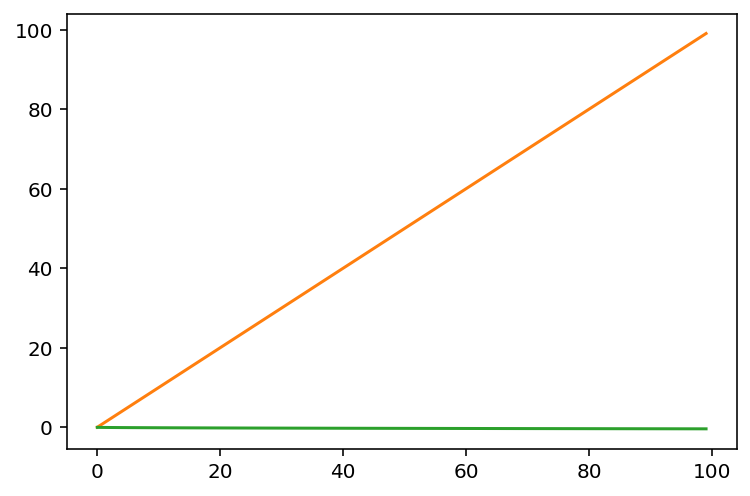

In [20]:
# Aggregate forecasted VaR
forecasted_values = np.empty([100, 2])

# Loop through each forecast period
for i in range(0, 100):
    # Save the time horizon i
    forecasted_values[i, 0] = i
    # Save the forecasted VaR 95
    forecasted_values[i, 1] = var_95 * np.sqrt(i + 1)
    
# Plot
plt.plot(i)
plt.plot(forecasted_values);

## Random walk simulation
Stochastic or random movements are used in physics to represent particle and fluid movements, in mathematics to describe fractal behavior, and in finance to describe stock market movements

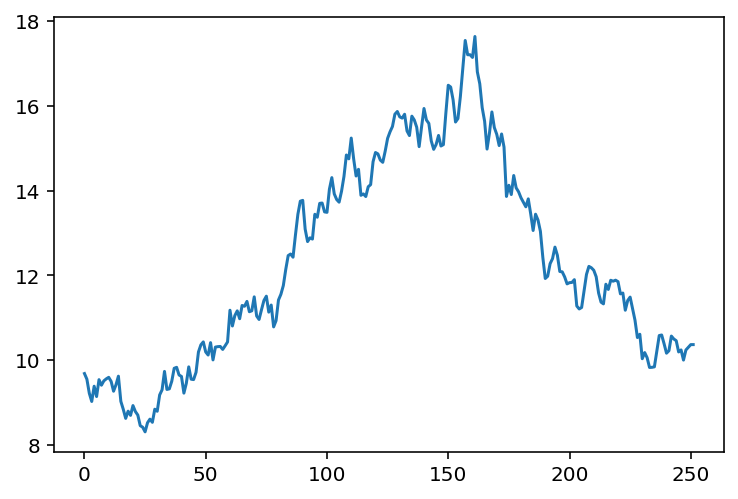

In [21]:
# Set simulation parameters
mu = np.mean(achc['Returns'])
vol = np.std(achc['Returns'])
T = 252
S0 = 10

# Add one to the random returns
rand_rets = np.random.normal(mu, vol, T) + 1

# Forecasted random walk
forecasted_values = S0 * rand_rets.cumprod()

plt.plot(range(0, T), forecasted_values)
plt.show()

## Monte Carlo simulations
Monte Carlo simulations are used to model a wide range of possibilities .
Monte Carlos can be constructed in many different ways, but all of them involve generating a large number of random variants of a given model, allowing a wide distribution of possible paths to be analyzed. This can allow you to build a comprehensive forecast possibilities to sample from without a large amount of historical data.

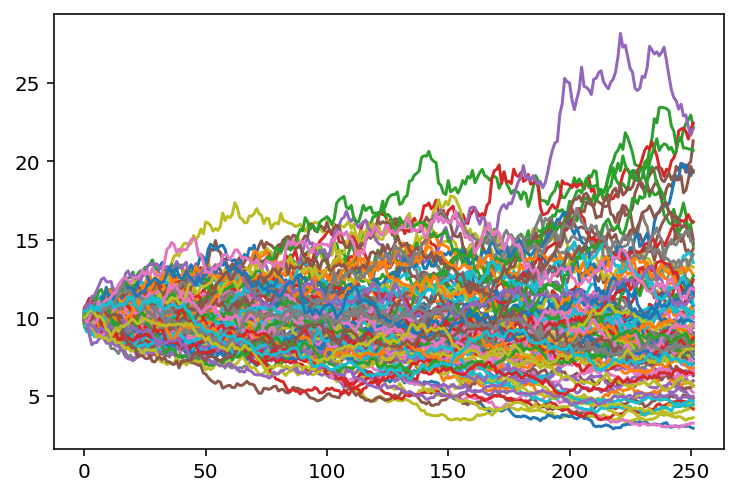

In [22]:
# Loop through 100 simulations
for i in range(100):
    
    # Generate the random returns
    rand_rets = np.random.normal(mu, vol, T) + 1
    
    # Create the Monte Carlo path
    forecasted_values = S0 *(rand_rets).cumprod()
    
    # Plot path
    plt.plot(range(T), forecasted_values)
    
plt.show()

## Monte Carlo VaR

Both the return values and the Monte Carlo paths can be used for analysis of everything ranging from option pricing models and hedging, to portfolio optimization and trading strategies

Aggregate the returns data at each iteration, use the resulting values to forecast parametric VaR(99)

In [23]:
# Aggregate the returns
sim_returns = []

# Loop through 100 simulations
for i in range(100):
    
    # Generate random walk
    rand_rets = np.random.normal(mu, vol, T)
    
    # Save the results
    sim_returns.append(rand_rets)
    
# Calculate the VaR(99)
var_99 = np.percentile(sim_returns, 1)
print('Parametric VaR(99): ', round(100 * var_99, 2), '%')

Parametric VaR(99):  -5.84 %
